# Image classification model

The following Jupyter Notebooks showcases a letter classification model, which was trained on the english alphabet.

## Prerequisites
For executing the notebook, multiple packages are required. Additionally, the following package from this GitHub repo is required to run `summary(model,...)`
`$ pip install torchsummary` or `git clone https://github.com/sksq96/pytorch-summary`. This package is used to display the model in a similar way to Keras

The following packages are used in **ImageTransferLearning.py**:

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
############## TENSORBOARD ########################
from torch.utils.tensorboard import SummaryWriter
###################################################
############## CUSTOM PACKAGE #####################
from HelperFunctions.HelperPhases import *
###################################################

The custom package **HelperFunctions.HelperPhases** consists of the following imports:

In [15]:
import torch
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
############## PROGESS BAR ########################
import sys
import time
###################################################

## Model

In [16]:
from LetterNeuralNet import *

### model parameters
* `device`: device on which the tensors are being processed for example: "cuda", "cpu", "dml"
* `confusionmatrixdevice`: device on which the tensors are being processed for creating the confusionmatrix example: "cuda", "cpu", "dml"
* `all_classes`: list of all possible classes
* `DATASETPATH`: path of the EMNIST dataset
* `MODELFOLDER`: folder path of the model. This model folder is used for loading and saving the trained model
* `num_epochs`: number of training epochs
* `batch_size`: number of color samples used per training/testing step
* `learning_rate`: base learning rate
* `num_workers`: number of used workers for the dataloader
* `pin_memory`: boolean type to use pinned memory, which helps in reducing the loading time of the dataloader
* `load_model_from_file`: parameter to determine if the model should be loaded --> 1 == true & 0 == false
* `save_trained_model`: parameter to determine if the model should be saved --> 1 == true & 0 == false

#### default values used for this model

* The parameter `input_size = (1,28,28)` can't be changed, because the size of convolutional layers is calculated based on the given input.
* The result of multiple tests with different `batch_size` values resulted in the following conclusion, that the value of `batch_size` needs to be equal or smaller than the classes to minimize overfitting. In this case I choose `batch_size = 26` to minimize overfitting and maximize the computation speed.
* The parameter has the following value to minimize overfitting `learning_rate = 0.001` . By choosing a higher learning rate the model has a worse generalization of letter recognition.

In [17]:
# dml only works if there is an amd gpu
device = torch.device("dml")
confusionmatrixdevice = torch.device('cpu')

all_classes = ["A", "B", "C", "D", "E", "F",
               "G", "H", "I", "J", "K", "L",
               "M", "N", "O", "P", "Q", "R",
               "S", "T", "U", "V", "W", "X",
               "Y", "Z"]
# Paths
DATASETPATH = 'C:/Users/matri/Desktop/Informatikprojekt/Backups/BackupNew/TextRecognition/data'
MODELFOLDER = './Models/'
# Parameter
num_epochs = 10
batch_size = 26
learning_rate = 0.001
num_workers = 6
pin_memory = True

It is important to always check if `load_model_from_file` is set to `0` before training a model, otherwise a trained model could be overwritten

In [18]:
# 1 == True ; 0 == False
load_model_from_file = 0
save_trained_model = 0

If `save_trained_model` is set to `1` the user should check the following settings to **NOT** overwrite a trained model. The manual Filename setting should only be used for loading a trained model to minimize the risk of accidentally overwriting a trained model!

In [19]:
# Automatic Filename for loading and saving
learning_rate_string = str(learning_rate).replace('.', '')
MiddleFilename = f"NE{num_epochs}BS{batch_size}LR{learning_rate_string}"
EndFilename = ".pth"
FILE = f"{MODELFOLDER}LetterNeuralNet{MiddleFilename}{EndFilename}"

# Manuel Filename for loading
# FILEPATH = "LetterNeuralNetNE10BS26LR0001.pth"
# FILE = f"{MODELFOLDER}{FILEPATH}"

#### model creation
For the first phase a model for letter recognition needs to be trained. The letter recognition uses a convolutional neural network with two convolutional layer and pooling layer for each convolutional layer. The input size for the model is a grayscale image of size **28x28**.

In [20]:
model = ConvNet().to(device)

#### criterion and optimizer
I chose the cross entropy loss function, because I have a model for multilabel classification. As an optimizer I used Adam, because it is one of the popular optimizer.
In the following code both can be changed to different ones:

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### training and test data loader
* for determining the size of `num_workers` you should never exceed the number of cores in your CPU. By increasing the size of `num_workers` to `2`, I could decrease the duration of the training phase to 85% of the duration with `num_workers = 0`. In my case that would be **5min** less in each epoch.
Info: If the notebook throws an error with `num_workers > 0` then there could be a compatibility problem with your hardware, and you must use `num_workers = 0`

In [22]:
train_loader, test_loader = dataloaderSetup(num_workers, pin_memory)

### Input
The following output shows the size of each individual data:

In [23]:
image, label = next(iter(train_loader))
print(f"batch shape of letters: {image.size()}")
print(f"batch shape of labels: {label.size()}")

batch shape of letters: torch.Size([26, 1, 28, 28])
batch shape of labels: torch.Size([26])


### Model summary
I chose to create an own convolutional neural network, because most of the pretrained models have RGB images with size **224x224** as an input and I would need to do unnecessary modifications to the EMNIST Dataset.

The following code snippet of the `ConvNet` class shows the first layers of the convolutional neural network. These two convolutional layers with each having a pooling layers are used for feature extraction from the given image.

```python
x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 12, 12
x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 4, 4
```

After the feature extraction the graph is flattened and three linear layers are being used for the class classification.

```python
x = x.view(-1, 16 * 4 * 4)  # -> n, 256
x = F.relu(self.fc1(x))  # -> n, 120
x = F.relu(self.fc2(x))  # -> n, 84
x = self.fc3(x)  # -> n, 26
```

The formulas that I used to determine the size of each convolutional layer can be found in the corresponding **READ.ME** file.

In [24]:
from torchsummary import summary

model.to("cpu")
summary(model, input_size=(1,28,28)) # function doesn't have "dml" as an option
model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 26]           2,210
Total params: 45,786
Trainable params: 45,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=26, bias=True)
)

### Examples from the color dataset
I used the EMNIST Dataset for training a generalized model for letter recognition with different fonts. The EMNIST Dataset for letters contains **145,600** images of handwritten letters. Each image is an grayscale image of size **28x28**. Every letter in the dataset is white with a black background.
Here are some examples:

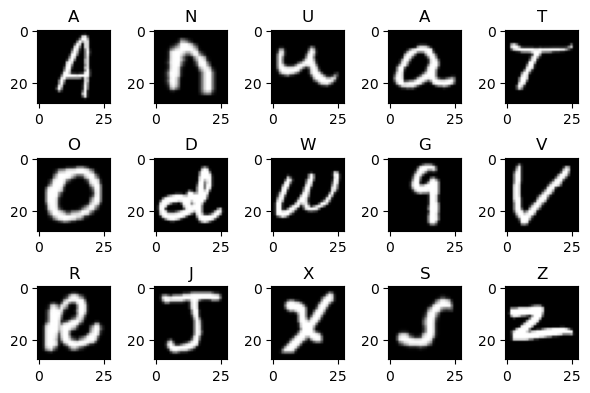

In [25]:
columns = 5
rows = 3
fig, ax = plt.subplots(rows, columns, dpi=100)
ax = ax.ravel()
for i, (image, labels) in enumerate(train_loader):
    if i == rows:
        break
    for j, (img) in enumerate(image):
        if i*columns+j>=columns*rows:
            break
        np_array = img.numpy()
        np_array = np_array.swapaxes(0, 2)
        ax[i*columns+j].imshow(np_array, cmap="gray")
        ax[i*columns+j].set_title(all_classes[labels[j]-1]) # set title
fig.tight_layout()
plt.show()

## Both Phases

### Training phase
* `labels_start_at` is used if all labels start at 1 instead of 0
* `print_every_x_percent` states when the current accuracy and loss gets printed and the accuracy and loss graph are updated in tensor board

In the training phase of the model a progress bar with the remaining time as well as the accuracy and loss is displayed. After every epoch a confusion matrix is generated for tensor board as well as a plot visible in the outputs.
Info: If the an image dataset with a similar size is used, then `device="dml"` or `device="cuda"` is fastest device for the confusion matrix as well as the training phase. If the dataset is smaller then `device=cpu` could be faster because of the tensors don't need to be moved between GPU and CPU, but in most cases the device needs to be on the GPU.

In [26]:
labels_start_at = 1
print_every_x_percent = 0.1

model = trainingPhase(model, criterion, optimizer, train_loader, num_epochs, print_every_x_percent, save_trained_model, device, confusionmatrixdevice, writer, FILE, all_classes, labels_start_at)

Epoch [1/1], Step [480/4800], Accuracy: 0.0383, Loss: 3.2734                                                  

Epoch [1/1], Step [960/4800], Accuracy: 0.0373, Loss: 3.2799                                                  



KeyboardInterrupt: 

### Testing phase
* `output_examples_check` is used to determine if an output should be given for displaying all false guessed batches by the model

In the testing phase of the model a progress bar with the remaining time is displayed. At the end a confusion matrix is generated for tensor board as well as a plot visible in the outputs.

In [ ]:
output_examples_check = 0

testingPhase(model, test_loader, writer, FILE, all_classes, labels_start_at, confusionmatrixdevice, output_examples_check)